In [2]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV


## Dataset preparation

In [3]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
len(df[df.plastic!=-1])

1161

In [4]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
df = df[df.plastic!=-1]
df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
len(df_plastic), len(df_noplastic)

(567, 594)

In [5]:
partition = 0.89

rand_ind_p = np.random.randint(0, len(df_plastic), int(partition*len(df_plastic)))
rand_ind_np = np.random.randint(0, len(df_noplastic), int(partition*len(df_noplastic)))

training_set = pd.concat([df_plastic.loc[rand_ind_p, ['patch_filename', 'plastic']], df_noplastic.loc[rand_ind_np, ['patch_filename', 'plastic']]]).reset_index()
validation_set = pd.merge(df.loc[:, ['patch_filename', 'plastic']], training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1).reset_index()

len(training_set), len(validation_set)

(1032, 482)

In [57]:
def prepareData(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            feat, _ = np.histogram(im, bins = 100)
            data.append(feat)
            labels.append(df.loc[i, 'plastic'])
    return data, labels


In [6]:
training_data, training_labels = prepareData(training_set)
test_data, test_labels = prepareData(validation_set)

X = np.array(training_data + test_data)
y = np.array(training_labels + test_labels)

## SVM 

In [7]:
kf = KFold(n_splits=3, shuffle=True)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
scores = ["precision", "recall"]
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring="%s_macro" % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

# Tuning hyper-parameters for precision



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g

In [85]:
kf = KFold(n_splits=3, shuffle=True)
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(training_data, training_labels)
rbf_svc.score(test_data, test_labels)

0.696969696969697

## Random Forest Classifier 

In [58]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [59]:
training_data, training_labels = prepareData(training_set)
test_data, test_labels = prepareData(validation_set)

In [61]:
rfc = RandomForestClassifier(n_estimators=10, max_features=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(training_data, training_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=31; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=31; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=31; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=115; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=115; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=115; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; tota

In [78]:
best_rfc = rf_random.best_estimator_
best_rfc.fit(training_data, training_labels)
pred_probs_rf = best_rfc.predict_proba(test_data)[:, 1]
accuracy_score(test_labels, best_rfc.predict(test_data))
print(classification_report(test_labels,  best_rfc.predict(test_data)))

              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       201
         1.0       0.79      0.76      0.77       225

    accuracy                           0.77       426
   macro avg       0.77      0.77      0.77       426
weighted avg       0.77      0.77      0.77       426



## CNN 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-02-08 09:32:49.235714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 09:32:49.235793: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
def prepareDataNN(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
    return data, labels

In [8]:
training_data, training_labels = prepareDataNN(training_set)
test_data, test_labels = prepareDataNN(validation_set)
training_data += test_data
training_labels += test_labels

In [9]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomTranslation(0.8, 0.5),
      layers.RandomZoom(0.5),
      layers.RandomContrast(0.7),
    ]
)

2022-02-08 09:33:12.817107: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-08 09:33:12.817188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giorgia-PX60-6QE): /proc/driver/nvidia/version does not exist
2022-02-08 09:33:12.837688: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Architecture 
    x = layers.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

image_size = (256, 256, 3)
model = make_model(input_shape=image_size , num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [23]:
epochs = 500

callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/save_at_{epoch}.h5", save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=callbacks, shuffle=True, batch_size=32, validation_split=.15
)

Epoch 1/500
70/70 [==============================] - 49s 679ms/step - loss: 0.7261 - accuracy: 0.6634 - val_loss: 0.6795 - val_accuracy: 0.5455
Epoch 2/500
70/70 [==============================] - 49s 706ms/step - loss: 0.7016 - accuracy: 0.6670 - val_loss: 0.6683 - val_accuracy: 0.6364
Epoch 3/500
70/70 [==============================] - 48s 682ms/step - loss: 0.6483 - accuracy: 0.6580 - val_loss: 0.6941 - val_accuracy: 0.5051
Epoch 4/500
70/70 [==============================] - 48s 688ms/step - loss: 0.6199 - accuracy: 0.6652 - val_loss: 0.6449 - val_accuracy: 0.6010
Epoch 5/500
70/70 [==============================] - 48s 681ms/step - loss: 0.6368 - accuracy: 0.6634 - val_loss: 0.6332 - val_accuracy: 0.6414
Epoch 6/500
70/70 [==============================] - 47s 677ms/step - loss: 0.5780 - accuracy: 0.6857 - val_loss: 0.7103 - val_accuracy: 0.5758
Epoch 7/500
70/70 [==============================] - 44s 634ms/step - loss: 0.6102 - accuracy: 0.6661 - val_loss: 0.6916 - val_accuracy:

In [13]:
model.load_weights("ckpts/save_at_391.h5")
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [39]:
import itertools
#loss, acc = model.evaluate(np.array(test_data), np.array(test_labels), verbose=2)

predictions = model.predict(np.array(test_data))
df_pred = pd.DataFrame(data={"pred_probability":list(itertools.chain.from_iterable(predictions)),"target":test_labels})
pred_class = []
for i in range(len(df_pred)):
    if df_pred.loc[i,"pred_probability"] >= .5:
        pred_class.append(1)
    else:
        pred_class.append(0)
df_pred["pred_class"] = pred_class


In [41]:
df_misclassified = pd.DataFrame()
print(classification_report(test_labels, pred_class))

              precision    recall  f1-score   support

         0.0       0.64      0.91      0.75       201
         1.0       0.87      0.55      0.68       225

    accuracy                           0.72       426
   macro avg       0.76      0.73      0.72       426
weighted avg       0.77      0.72      0.71       426



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Recall')

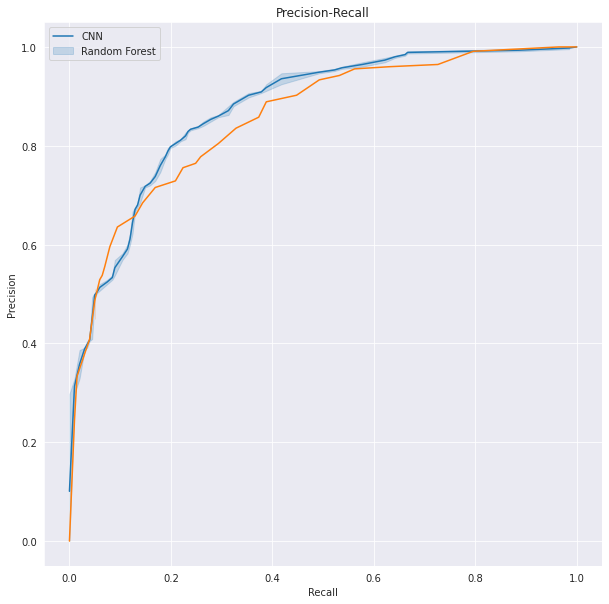

In [79]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve

import seaborn as sns 

plt.figure(figsize=(10,10))
plt.title("Precision-Recall")
sns.set_style("darkgrid")
# CNN
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
sns.lineplot(fpr, tpr, label="CNN")

# RF
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rf)
sns.lineplot(fpr, tpr, label="Random Forest")
plt.legend(["CNN", "Random Forest"])

plt.ylabel("Precision")
plt.xlabel("Recall")